<a href="https://colab.research.google.com/github/yudhistirank/EcoSense-C242-PS114/blob/ML/Model1_Bangkit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import random
import os
import zipfile
from PIL import Image
import io as BytesIO
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_tuner as kt
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.17.1


In [ ]:
import tensorflow.keras as keras
print(keras.__version__)

3.5.0


**DATASET**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_file = r"/content/drive/My Drive/DATASET - Copy.zip"
path_folder = "path_fold"
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(path_folder)

In [ ]:
train_dir = os.path.join(path_folder, 'TRAIN')
test_dir = os.path.join(path_folder, 'TEST')

In [ ]:
train_dir_O = os.listdir(os.path.join(train_dir, 'O'))
train_dir_R = os.listdir(os.path.join(train_dir, 'R'))
test_dir_O = os.listdir(os.path.join(test_dir, 'O'))
test_dir_R = os.listdir(os.path.join(test_dir, 'R'))

print(f'Total train O images: {len(train_dir_O)}')
print(f'Total train R images: {len(train_dir_R)}')
print(f'Total test O images: {len(test_dir_O)}')
print(f'Total test R images: {len(test_dir_R)}')

Total train O images: 12575
Total train R images: 9999
Total test O images: 1411
Total test R images: 1112


Sample images from class 'O'


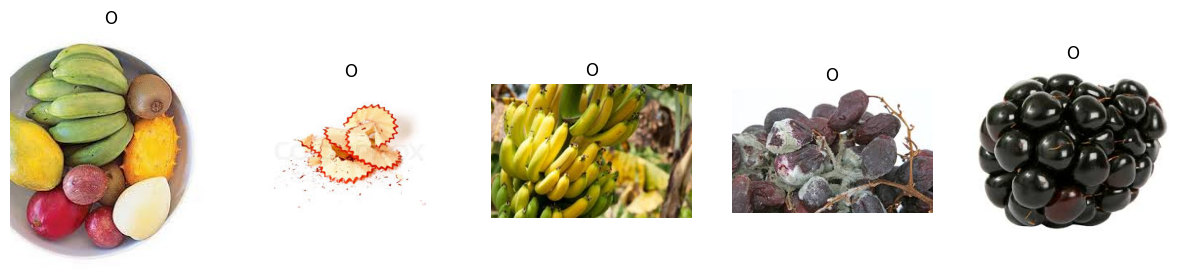

Sample images from class 'R'


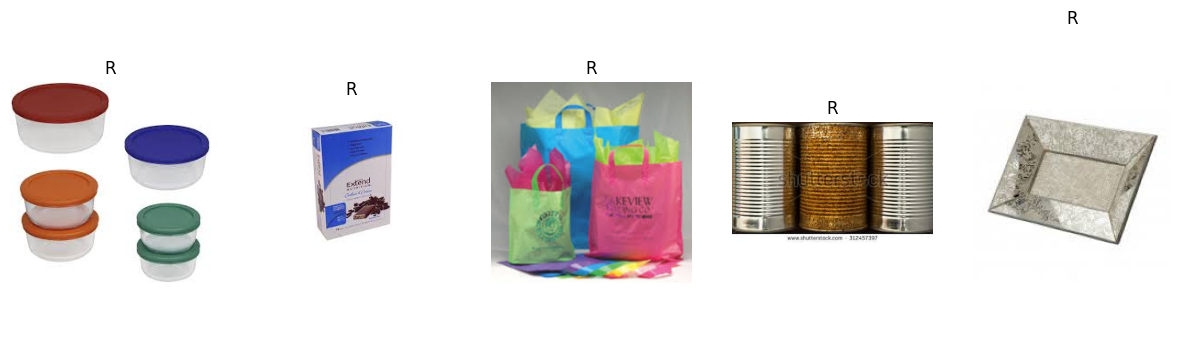

In [ ]:
def visualize_samples(folder_path, class_name, num_samples=5):
    class_folder = os.path.join(folder_path, class_name)
    sample_files = random.sample(os.listdir(class_folder), num_samples)
    plt.figure(figsize=(15, 5))
    for i, file_name in enumerate(sample_files):
        img_path = os.path.join(class_folder, file_name)
        img = Image.open(img_path)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
    plt.show()

print("Sample images from class 'O'")
visualize_samples(train_dir, 'O')

print("Sample images from class 'R'")
visualize_samples(train_dir, 'R')

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(150, 150),
    batch_size=20,
    label_mode='categorical')

Found 22574 files belonging to 2 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(150, 150),
    batch_size=20,
    label_mode='categorical')

Found 2523 files belonging to 2 classes.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#model 1
import tensorflow as tf
from tensorflow.keras import layers, models

def build_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(150, 150, 3)),
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    return model

In [ ]:
model = build_model()
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 37, 37, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 18, 18, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 3,652,738 (13.93 MB)

 Trainable params: 3,650,818 (13.93 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

Epoch 1/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 85s 63ms/step - accuracy: 0.7730 - loss: 4.8233 - val_accuracy: 0.8962 - val_loss: 2.5118
Epoch 2/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 55s 49ms/step - accuracy: 0.8467 - loss: 2.2433 - val_accuracy: 0.8910 - val_loss: 1.2321
Epoch 3/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 82s 49ms/step - accuracy: 0.8591 - loss: 1.1281 - val_accuracy: 0.9049 - val_loss: 0.6011
Epoch 4/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 81s 48ms/step - accuracy: 0.8696 - loss: 0.6082 - val_accuracy: 0.9124 - val_loss: 0.3413
Epoch 5/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 82s 48ms/step - accuracy: 0.8772 - loss: 0.4080 - val_accuracy: 0.9199 - val_loss: 0.2629
Epoch 6/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 83s 49ms/step - accuracy: 0.8832 - loss: 0.3440 - val_accuracy: 0.9247 - val_loss: 0.2371
Epoch 7/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 81s 48ms/step - accuracy: 0.8903 - loss: 0.3179 - val_accuracy: 0.9314 - val_loss: 0.2294
Epoch 8/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 54s 47ms/step - accuracy: 0.9007 -

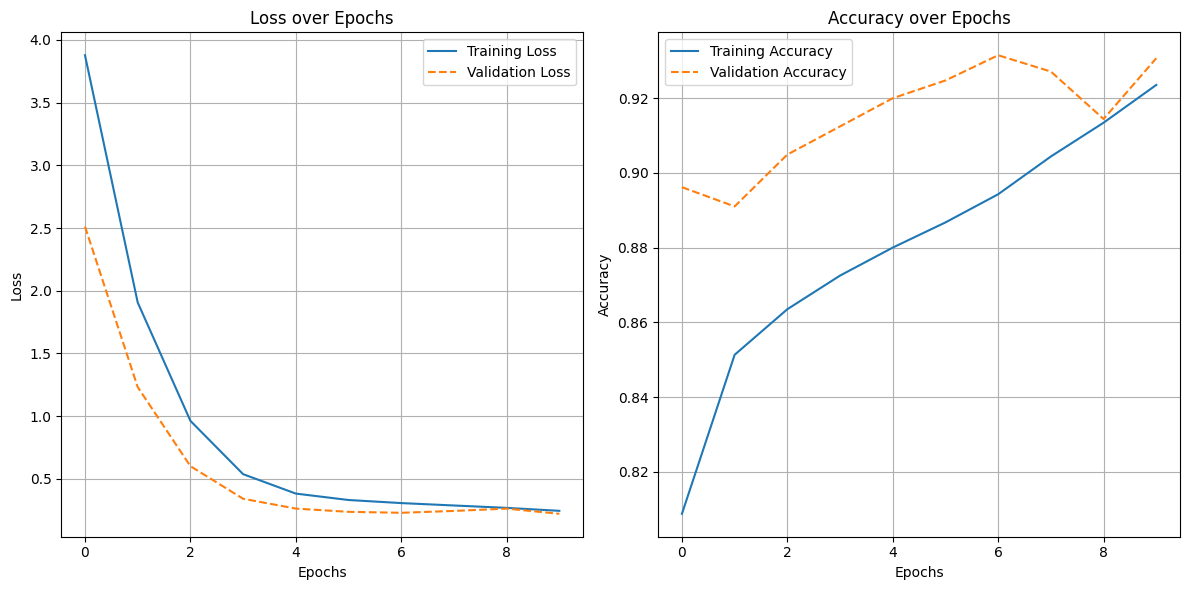

In [ ]:
# Plot perkembangan loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot perkembangan accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Tampilkan grafik
plt.tight_layout()
plt.show()

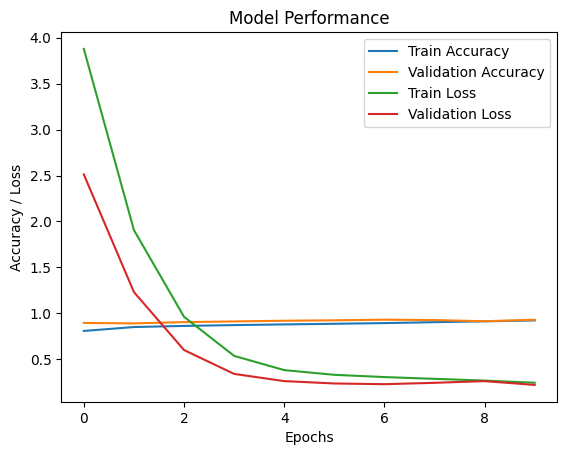

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Performance')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(validation_dataset)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9331 - loss: 0.2244
Validation Loss: 0.22141261398792267
Validation Accuracy: 0.9306381344795227


In [ ]:
model.save("klasifikasi_sampah1.h5")
print("Model telah disimpan ke file ecosense_model.h5")

Model telah disimpan ke file ecosense_model.h5


In [ ]:
model.save("klasifikasi_sampah1.keras")

In [ ]:
h5_model_path = 'klasifikasi_sampah1.keras'
model = tf.keras.models.load_model(h5_model_path)

# Buat converter dari model yang dimuat
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Konversi ke format TFLite
tflite_model = converter.convert()

# Simpan model TFLite ke file
tflite_model_path = 'model.tflite'
with open(tflite_model_path, 'wb') as f:
       f.write(tflite_model)

print(f"Model berhasil dikonversi dan disimpan sebagai {tflite_model_path}")

Saved artifact at '/tmp/tmphxpy4qkc'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  135695433450768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135697082150128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135695206682464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135695206681056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135695206690032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135695206688800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135695206687216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135695206678768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135697647735328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135697647740432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1356976477402

In [ ]:
!pip install --upgrade tflite-support